In [36]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.decomposition import NMF
from scipy.stats import skew, kurtosis

def tf_features(filepath):
    try:
        y, sr = librosa.load(filepath, sr=None)
        n_fft = 512
        hop_length = 256
        window = np.hanning(n_fft)

        S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)) ** 2
        E = np.sum(S)
        TFM = S / E if E != 0 else S

        model = NMF(n_components=1, init='random', random_state=0, max_iter=500)
        B = model.fit_transform(S)
        C = model.components_
        b = B[:, 0]
        c = C[0]

        t = np.arange(len(c))
        f = np.arange(len(b))

        t1 = np.sum(c * t) / E  
        t2 = np.sum(c * t**2) - (t1**2 / E)  

        f1 = np.sum(b * f) / E  
        f2 = np.sum(b * f**2) - (f1**2 / E)

        features = [t1, t2, f1, f2]

        sparsity = lambda x: np.log10((np.sqrt(len(x)) * np.sum(np.abs(x))) / (np.sqrt(np.sum(x ** 2)))) - 1
        features += [sparsity(b), sparsity(c)]

        discontinuity = lambda x: np.log10(np.sum(np.diff(x) ** 2))
        features += [discontinuity(b), discontinuity(c)]

        alpha = 2
        renyi = (1 / (1 - alpha)) * np.log2(np.sum(TFM ** alpha))
        features.append(renyi)

        features += [np.mean(b), np.std(b), np.mean(c), np.std(c)]
        features += [skew(b), kurtosis(b), skew(c), kurtosis(c)]

        return features

    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return [np.nan] * 17

In [37]:
 
base_path = "/Users/manyasharma/FINAL_PROJECT_(POLYP)"
data = []
labels_map = {'Polyp': 0, 'Healthy': 1}

for gender in ['Polyp', 'Healthy']:
    folder_path = os.path.join(base_path, gender)
    label = labels_map[gender]

    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.wav'):
            file_path = os.path.join(folder_path, file)
            features = tf_features(file_path)
            data.append([file, label] + features)

In [8]:
    columns = ['Filename','Label'] + [f'Feat_{i+1}' for i in range(17)]
    df = pd.DataFrame(data, columns=columns)
    df.shape
    df.to_csv("/Users/manyasharma/FINAL_PROJECT_(POLYP)/tf.csv", index=False)
    print("TF-NMF features saved to tf_nmf_features2.csv")

TF-NMF features saved to tf_nmf_features2.csv


In [1]:
import pandas as pd

df = pd.read_csv("tf.csv")
print(df.shape)       
df.head()            

(559, 19)


,Filename,Label,Feat_1,Feat_2,Feat_3,Feat_4,Feat_5,Feat_6,Feat_7,Feat_8,Feat_9,Feat_10,Feat_11,Feat_12,Feat_13,Feat_14,Feat_15,Feat_16,Feat_17
0,1052-a_h.wav,0,0.081337,1.620934e+06,0.009914,32976.500797,0.525737,1.023769,4.939417,0.928050,8.781259,2.514906,19.097866,4.115842,0.346906,12.225079,164.914575,-0.441512,3.158221
1,1052-a_l.wav,0,0.147287,3.223926e+06,0.009782,37387.036198,0.527963,1.177636,4.702548,0.849366,9.306941,1.903003,14.375990,3.037017,0.551892,12.339583,169.322509,-1.567680,3.021832
2,1052-a_lhl.wav,0,0.144557,7.097642e+06,0.006977,37311.618814,0.548958,1.235327,4.803924,1.133734,9.580804,2.398841,17.251152,3.683969,1.405058,11.248654,138.456302,0.719786,-0.667091
3,1052-a_n.wav,0,0.103267,6.555314e+05,0.015963,22219.006245,0.527059,0.979078,4.455338,0.968007,8.593815,1.536899,11.634923,2.439525,1.000516,11.771323,153.970339,0.369703,-0.997756
4,1052-i_h.wav,0,0.124169,1.531530e+06,0.011065,59982.966256,0.414366,1.078362,4.868686,1.438659,8.241549,1.731311,17.049610,2.874825,0.671734,12.857639,175.628857,0.028486,0.401937


In [12]:
df = pd.read_csv("/Users/manyasharma/FINAL_PROJECT_(POLYP)/tf.csv")
y = df['Label']
X=df.drop('Filename',axis=1)
X = df.drop('Label', axis=1)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (447, 18)
Test size: (112, 18)


In [36]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Accuracy: 75.89 %

 Classification Report:
              precision    recall  f1-score   support

       Polyp       0.77      0.73      0.75        56
     Healthy       0.75      0.79      0.77        56

    accuracy                           0.76       112
   macro avg       0.76      0.76      0.76       112
weighted avg       0.76      0.76      0.76       112



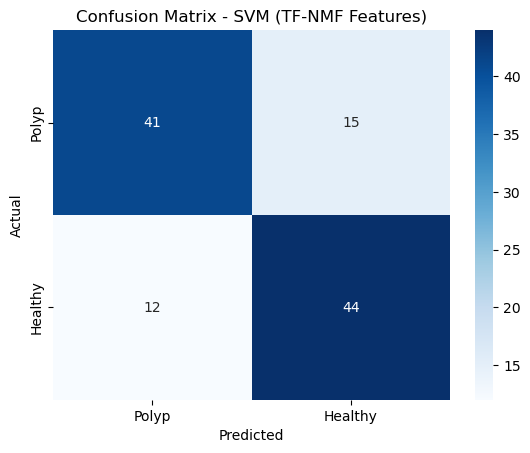

In [14]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv("tf.csv")

X = df.drop(columns=["Filename", "Label"])
y = df["Label"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train, y_train)


y_pred = svm_model.predict(X_test)


print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Polyp", "Healthy"]))


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Polyp", "Healthy"], yticklabels=["Polyp", "Healthy"])
plt.title("Confusion Matrix - SVM (TF-NMF Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [2]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv("tf.csv")

X = df.drop(columns=["Filename", "Label"])
y = df["Label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sss = StratifiedShuffleSplit(n_splits=1, test_size=20, random_state=42)

for train_idx, test_idx in sss.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [4]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(SVC(), param_grid, cv=5)
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear', 'poly']})

In [5]:
y_pred = grid_svm.predict(X_test)

print("Best Parameters:", grid_svm.best_params_)
print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\n Classification Report:\n", classification_report(y_test, y_pred, target_names=['Polyp', 'Healthy']))

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 85.0 %

 Classification Report:
               precision    recall  f1-score   support

       Polyp       0.82      0.90      0.86        10
     Healthy       0.89      0.80      0.84        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



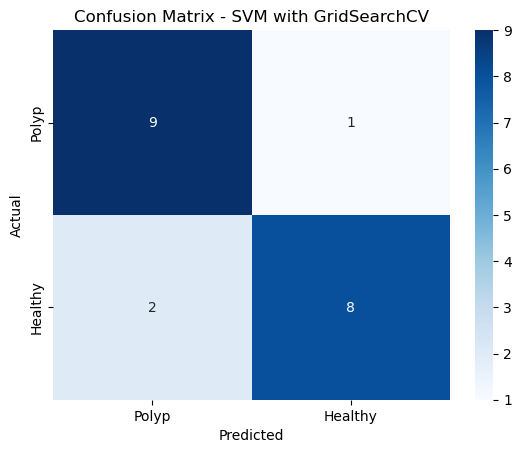

In [8]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Polyp","Healthy"], yticklabels=["Polyp","Healthy"])
plt.title("Confusion Matrix - SVM with GridSearchCV")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [9]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

Accuracy: 90.0 %

 Classification Report:
              precision    recall  f1-score   support

        Male       0.90      0.90      0.90        10
      Female       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



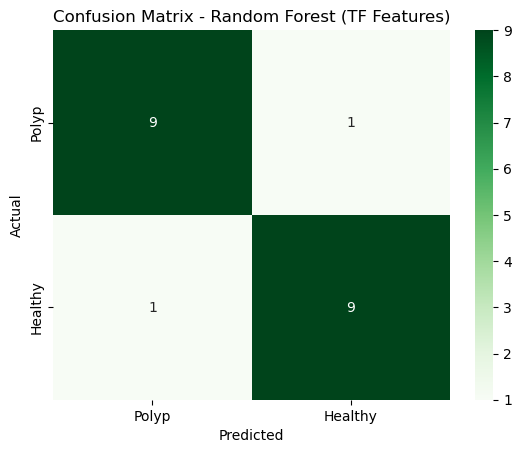

In [10]:
df = pd.read_csv("tf.csv")

X = df.drop(columns=["Filename", "Label"])
y = df["Label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sss = StratifiedShuffleSplit(n_splits=1, test_size=20, random_state=42)

for train_idx, test_idx in sss.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Male", "Female"]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Polyp', 'Healthy'] , yticklabels=['Polyp', 'Healthy'])
plt.title("Confusion Matrix - Random Forest (TF Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 17 TF features and 13 mfcc features = 30 

In [11]:
import pandas as pd

In [12]:
mfcc_df = pd.read_csv("mfccgfcc_features.csv")
tf_df = pd.read_csv("tf.csv")


tf_df = tf_df.drop(columns=["Filename"])

merged_df = pd.concat([mfcc_df, tf_df.drop(columns=["Label"])], axis=1)

merged_df.to_csv("combined_30_features.csv", index=False)
print("Merged without filename, using row order")

Merged without filename, using row order


In [13]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv("combined_30_features.csv")

X = df.drop(columns=["Label"])  
y = df["Label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [16]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(), param_grid, cv=5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 88.39 %

 Classification Report:
               precision    recall  f1-score   support

       Polyp       0.89      0.88      0.88        56
     Healthy       0.88      0.89      0.88        56

    accuracy                           0.88       112
   macro avg       0.88      0.88      0.88       112
weighted avg       0.88      0.88      0.88       112



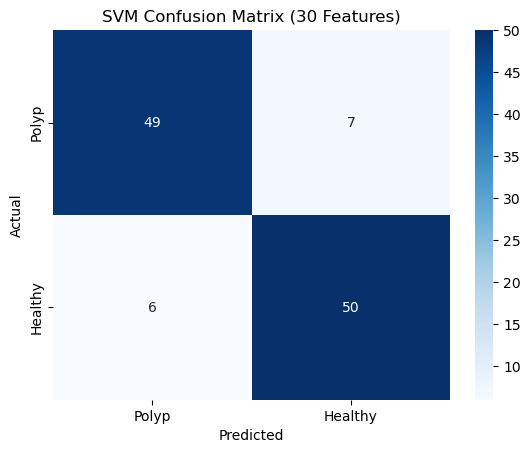

In [17]:
print("Best Parameters:", grid.best_params_)
print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\n Classification Report:\n", classification_report(y_test, y_pred, target_names=["Polyp","Healthy"]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Polyp","Healthy"], yticklabels=["Polyp","Healthy"])
plt.title("SVM Confusion Matrix (30 Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy: 89.29 %

 Classification Report:
               precision    recall  f1-score   support

       Polyp       0.85      0.95      0.90        56
     Healthy       0.94      0.84      0.89        56

    accuracy                           0.89       112
   macro avg       0.90      0.89      0.89       112
weighted avg       0.90      0.89      0.89       112



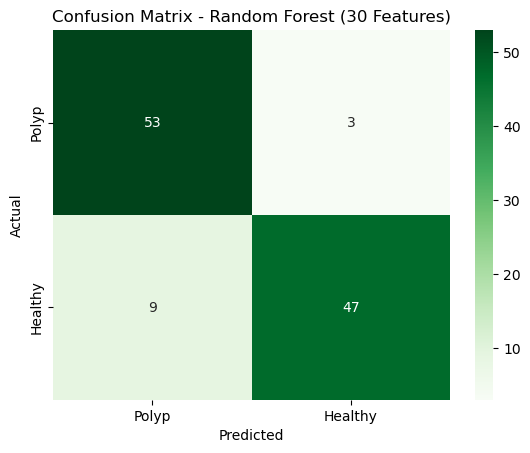

In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("combined_30_features.csv")
X = df.drop(columns=["Label"])
y = df["Label"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\n Classification Report:\n", classification_report(y_test, y_pred, target_names=["Polyp","Healthy"]))


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=["Polyp","Healthy"], yticklabels=["Polyp","Healthy"])
plt.title("Confusion Matrix - Random Forest (30 Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [65]:
import joblib

In [102]:
joblib.dump(rf_model, "rf_model_30_features.pkl")
joblib.dump(scaler, "scaler_30_features.pkl")

joblib.dump(grid.best_estimator_, "svm_model_30_features.pkl")
joblib.dump(scaler, "svm_scaler_30_features.pkl")

print("SVM model and scaler saved successfully.")
print("Model and scaler saved successfully.")


SVM model and scaler saved successfully.
Model and scaler saved successfully.


In [103]:
loaded_model = joblib.load("rf_model_30_features.pkl")
loaded_scaler = joblib.load("scaler_30_features.pkl")

svm_model = joblib.load("svm_model_30_features.pkl")
svm_scaler = joblib.load("svm_scaler_30_features.pkl")